# **EDA Notebook Fall 2023 ML Herbarium**

#### Please note : The EDA for the datasets done in the Summer 2023 folder is already very extensive and we would like to add our own visualizations and approaches to it instead of re-analyzing the data from scratch.

#### About exploring multi-language Herbaria

For our project this semester, the client wants to expand the model to work on Chinese Herbarium Specimen. One source of images he recommended is the Chinese Virtual Herbarium. The data here is very well labeled and the images are high quality and clear. The only problem is that it is hard to download all the information at once and it may have to be done manually. We plan on asking our clients to contact the Chinese Virtual Herbarium partners to see if there is a way for us to gain access to an API or a dataset of a large amount of images.    

<img src="cvh_images/image1.jpeg" width="800" height="400">
<img src="cvh_images/image2.png" width="800" height="400">

[Here](https://www.cvh.ac.cn/spms/detail.php?id=e6f6b883) is a link to an example Herbarium specimen. In this specimen, there are typed and handwritten labels and the link to each specimen has the ground truth labels in typed text. There are two images above, the first image is the actual sample and the second image is the labels for the image. One potential problem is that the truth labels are in Chinese, so there may be errors that come from translating the lables from Chinese to English. Nonetheless, we believe that if we can easily aquire all this data, this data would be extremely useful for training and testing our model on specimen with Chinese labels. 

Through exploring the website, the Chinese Virtual Herbarium has **473 unique families, 3932 unique genera and 63346 species**. The dataset collected by the 2023 Spring team has **236629 unique species** total. Even if we do not use the Chinese dataset to train our model on chinese text labels, the dataset may be valuable in training an image classifier because of the larger variety of samples. There are **8,266,532** samples available on the website. For the GBIF dataset that the previous teams scraped, there were **7,982,741** sample images. 

<img src="cvh_images/image3.png" width="800" height="400">

Above is a graph of the number of specimen collected per year. Most of the herbarium specimen were collected between **1956 and 1964**, so the data itself may not be as useful to the researchers who are actually using this data, but the data should still be useful for training our model. Most, if not all of the specimen are located in China.

<img src="cvh_images/image4.png" width="800" height="400">

For a Cyrilic dataset, we can use the Moscow University Herbarium (MW). https://en.herbariumle.ru/?t=occ. An example image is above. This dataset faces the same problem as the Chinese dataset however where it is hard to access the data on a larger scale. We would need to talk to our clients again to reach out to the people responsible for this Herbarium. There seems to be a typed ledger for all the relevant labels in the image which would make this an ideal dataset. However, the labels are in Russian so some translation may be needed which could an extra element we need to account for. To understand this dataset more, we would need to get access to it and then perform EDA on it once again. 


# EDA for the primary and secondary task

In [1]:
import requests
import shutil
import os
import time
import math
import pandas
import json
from tqdm import tqdm
import glob
import random
from PIL import Image
import imghdr
from sklearn.model_selection import train_test_split
# Multiprocessing stuff
import multiprocessing as mp
NUM_CORES = min(mp.cpu_count(), 50)

# Some CV/DL module
import numpy as np
np.__version__
import matplotlib.pyplot as plt
import cv2

# ! pip install python-dwca-reader
from dwca.read import DwCAReader
from dwca.darwincore.utils import qualname as qn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Some hyper-parameters
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = './data'
width=256
height=256
depth=3

timestr = time.strftime("%Y%m%d-%H%M%S")
DATASET_CSV = "//projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/data.csv"
DATASET_PATH = org_img_dir = "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/scraped-data/20220616-061434/"	# "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data/scraped-data/drago_testdata/"
craft_res_dir = org_img_dir.replace('/scraped-data/', '/CRAFT-results/')
seg_img_dir = org_img_dir.replace('/scraped-data/', '/seg-results/')

PERCENT_TO_SCRAPE = 0.0006
#PERCENT_TO_SCRAPE = 0.01252703
NUMBER_TO_SKIP = 0
OUTPUT_PATH = "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data-spring2023/TrOCR evaluation data/" #removed timestr - smriti
OUTPUT_PATH_IMAGES = "/projectnb/sparkgrp/ml-herbarium-grp/ml-herbarium-data-spring2023/TrOCR evaluation data/images/" + timestr + "/"
DATASET_URL = "https://occurrence-download.gbif.org/occurrence/download/request/0196625-210914110416597.zip"
DATASET_TYPE = ""

Note: There are 7,982,741 images available in GBIF database, but we only scrapped 4203 images for creating the evaluation dataset (which will be reviewed by the client). If you want to see the amount of data that we have, use the following code, or you can checkout the 'scraping' folder to scrape more data from the website.

```python
# If you want to read the data from that data.csv file
import pandas as pd
df = pd.read_csv(DATASET_PATH + DATASET_CSV, sep="\t")
DATASET_TYPE = "csv"
colnames = []
for col in df.columns:
    colnames.append(col)
print(f"colnames: {colnames}")
print(f"df.shape: {df.shape}")
```



## Converting the CSV data into a pandas data frame

In [3]:
df = pd.read_csv(DATASET_CSV, sep="\t")
DATASET_TYPE = "csv"
colnames = []
for col in df.columns:
    colnames.append(col)
print(f"colnames: {colnames}")
print(f"df.shape: {df.shape}")

/scratch/2902964.1.cds-gpu/ipykernel_1253295/1186810192.py:1: DtypeWarning: Columns (2,14,16,17,19,21,24,25,26,32,33,34,36,37,38,39,40,41,43,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATASET_CSV, sep="\t")


colnames: ['gbifID', 'datasetKey', 'occurrenceID', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'infraspecificEpithet', 'taxonRank', 'scientificName', 'verbatimScientificName', 'verbatimScientificNameAuthorship', 'countryCode', 'locality', 'stateProvince', 'occurrenceStatus', 'individualCount', 'publishingOrgKey', 'decimalLatitude', 'decimalLongitude', 'coordinateUncertaintyInMeters', 'coordinatePrecision', 'elevation', 'elevationAccuracy', 'depth', 'depthAccuracy', 'eventDate', 'day', 'month', 'year', 'taxonKey', 'speciesKey', 'basisOfRecord', 'institutionCode', 'collectionCode', 'catalogNumber', 'recordNumber', 'identifiedBy', 'dateIdentified', 'license', 'rightsHolder', 'recordedBy', 'typeStatus', 'establishmentMeans', 'lastInterpreted', 'mediaType', 'issue']
df.shape: (7982741, 50)


## Taking a look at the data csv

In [4]:
df.head()

,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
0,2417026544,af5f680a-e0cc-46c8-b623-ceeaab70aa9e,MHA0027832,Plantae,Tracheophyta,Liliopsida,Poales,Cyperaceae,Eriophorum,Eriophorum angustifolium,...,Syreyschikov D.,NaN,CC_BY_4_0,GBS RAN - Glavny Botanichesky Sad Rossijskoj A...,Syreyschikov D. | Smirnov P.,NaN,NaN,2022-03-25T12:48:46.119Z,StillImage,DIFFERENT_OWNER_INSTITUTION
1,2417026527,af5f680a-e0cc-46c8-b623-ceeaab70aa9e,MHA0027833,Plantae,Tracheophyta,Liliopsida,Poales,Cyperaceae,Eriophorum,Eriophorum angustifolium,...,Syreyschikov D.,NaN,CC_BY_4_0,GBS RAN - Glavny Botanichesky Sad Rossijskoj A...,Syreyschikov D. | Smirnov P.,NaN,NaN,2022-03-25T12:48:46.120Z,StillImage,DIFFERENT_OWNER_INSTITUTION
2,2458329530,af5f680a-e0cc-46c8-b623-ceeaab70aa9e,MHA0003877,Plantae,Tracheophyta,Liliopsida,Alismatales,Hydrocharitaceae,Elodea,Elodea canadensis,...,Identified by the collector,NaN,CC_BY_4_0,GBS RAN - Glavny Botanichesky Sad Rossijskoj A...,S.S. Ganeshin,NaN,NaN,2022-03-25T12:48:46.136Z,StillImage,DIFFERENT_OWNER_INSTITUTION
3,2417025838,af5f680a-e0cc-46c8-b623-ceeaab70aa9e,MHA0027817,Plantae,Tracheophyta,Liliopsida,Poales,Cyperaceae,Eriophorum,Eriophorum angustifolium,...,Syreyschikov D.,NaN,CC_BY_4_0,GBS RAN - Glavny Botanichesky Sad Rossijskoj A...,Syreyschikov D. | Smirnov P.,NaN,NaN,2022-03-25T12:48:46.142Z,StillImage,DIFFERENT_OWNER_INSTITUTION
4,2458328836,af5f680a-e0cc-46c8-b623-ceeaab70aa9e,MHA0003842,Plantae,Tracheophyta,Liliopsida,Alismatales,Butomaceae,Butomus,Butomus umbellatus,...,Chernyakovskaya-Reyneke,NaN,CC_BY_4_0,GBS RAN - Glavny Botanichesky Sad Rossijskoj A...,Chernyakovskaya-Reyneke,NaN,NaN,2022-03-25T12:48:46.168Z,StillImage,DIFFERENT_OWNER_INSTITUTION


## Fall 2023 Visualizations

### Checking which year were the most species identified in

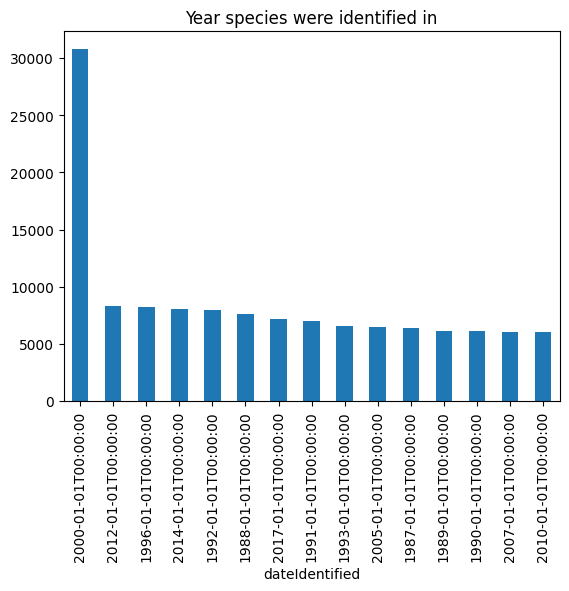

In [5]:
x = df['dateIdentified'].value_counts()[:15].plot(kind='bar',title = "Year species were identified in")


#### Observation : A large majority of the samples (30k+) were identified in the year 2000. 

### Year distribution of samples

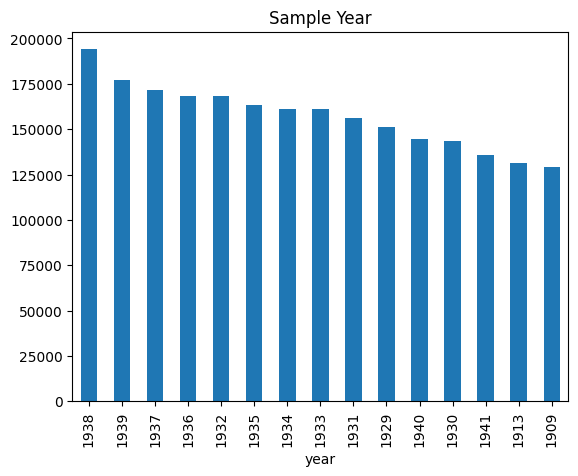

In [6]:
x = df['year'].value_counts()[:15].plot(kind='bar',title = "Sample Year")

### Locality information

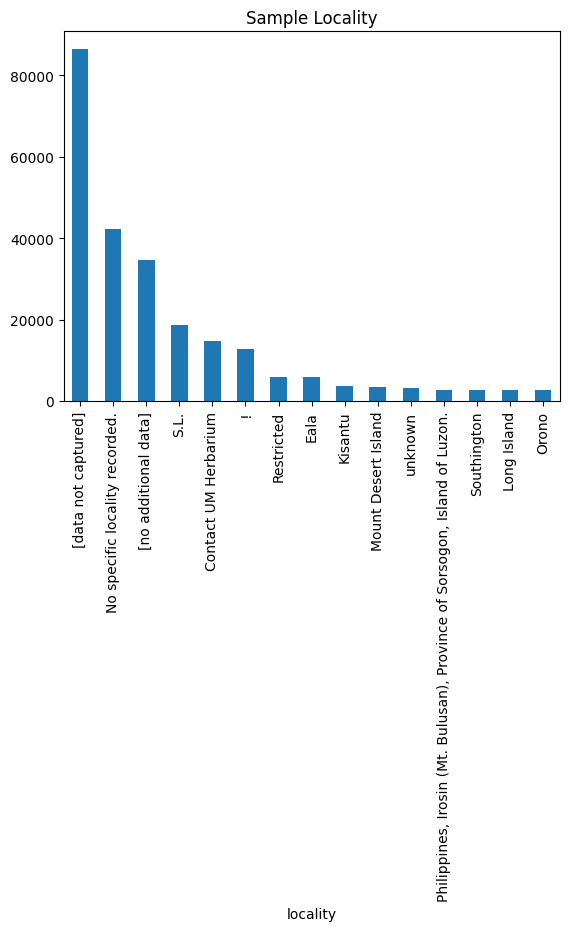

In [7]:
x = df['locality'].value_counts()[:15].plot(kind='bar',title = "Sample Locality");

We observe that most of the samples in data.csv do not have locality information available

### Looking at the most represented species' in our data (and who collected the species)

In [8]:
x = df['species'].value_counts()
#y = df.pivot(index='genus', columns='species', values=x)
print(f"We have {len(x)} species in total!")
x[:15]

We have 236629 species in total!


species
Panicum acuminatum         8852
Equisetum arvense          5499
Poa pratensis              5431
Festuca rubra              5374
Deschampsia cespitosa      4808
Poa secunda                4661
Cystopteris fragilis       4653
Pteridium aquilinum        4229
Achillea millefolium       3929
Persicaria lapathifolia    3790
Campanula rotundifolia     3666
Luzula multiflora          3573
Juniperus communis         3455
Juncus bufonius            3450
Persicaria amphibia        3430
Name: count, dtype: int64

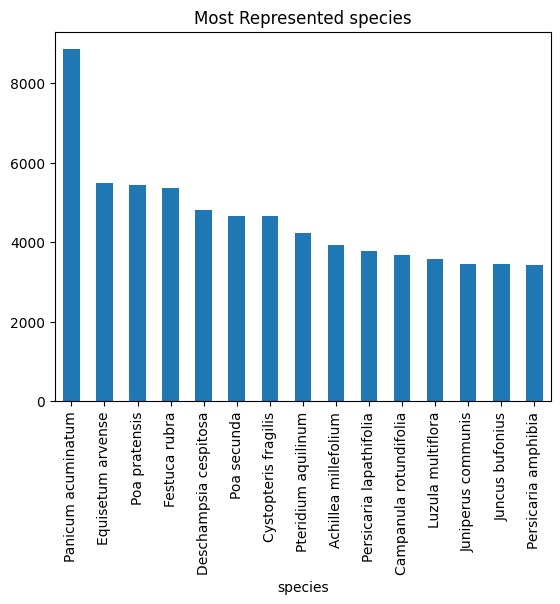

In [9]:
df['species'].value_counts()[:15].plot(kind='bar',title = "Most Represented species");

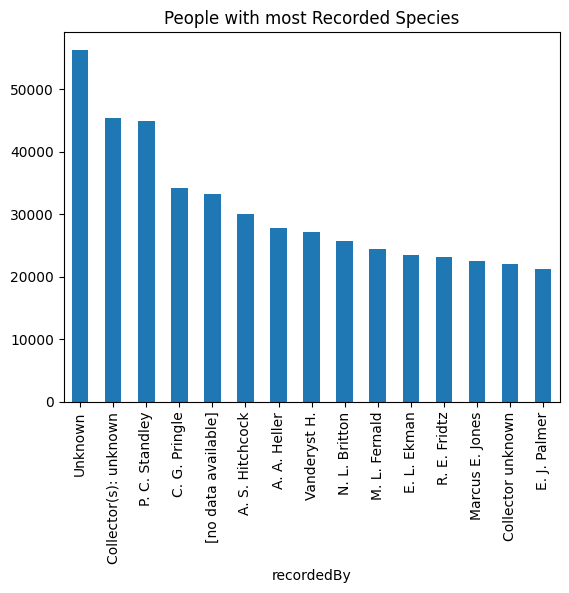

In [10]:
x = df['recordedBy'].value_counts()
x[:15].plot(kind='bar',title = "People with most Recorded Species");

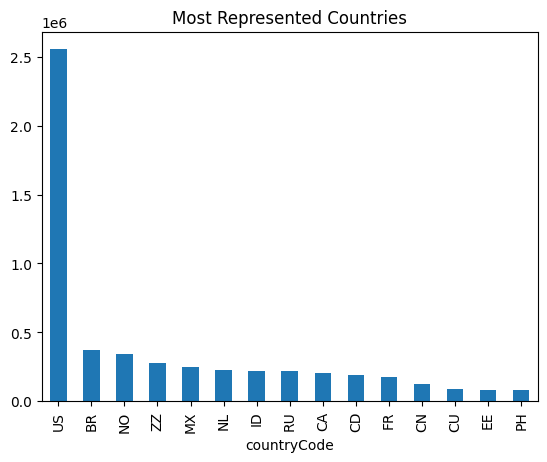

In [11]:
# print(df["countryCode"].describe())
x = df['countryCode'].value_counts()
x[:15].plot(kind='bar',title = "Most Represented Countries");

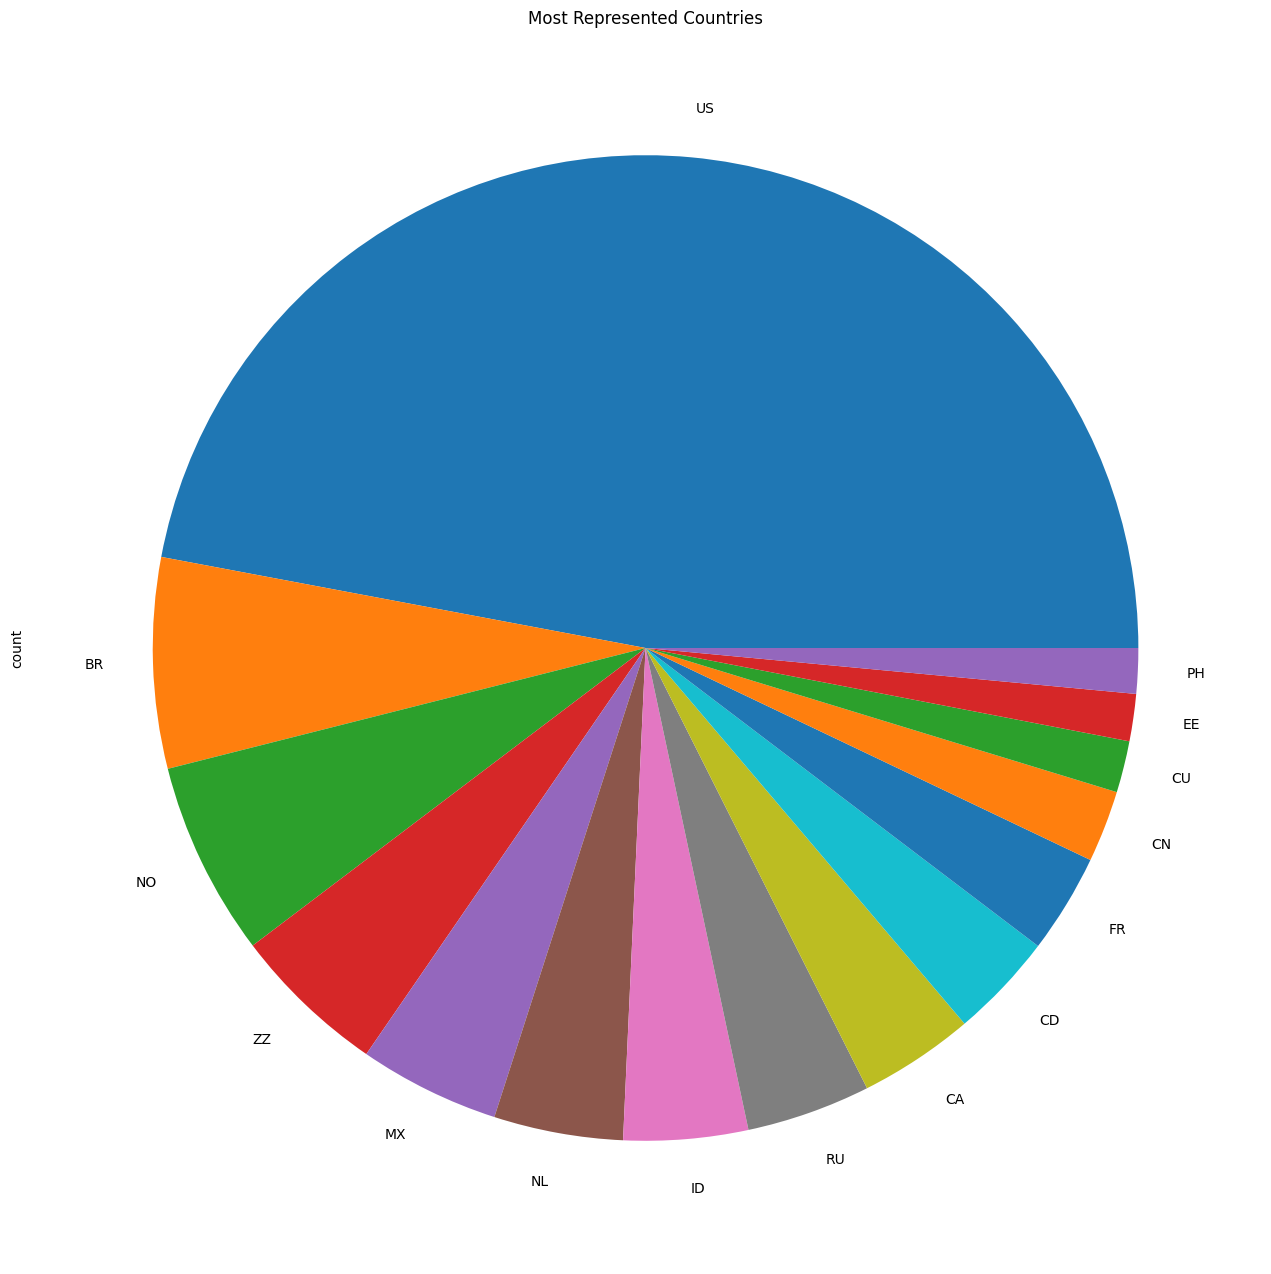

In [12]:
kwargs = dict(

    startangle = 90,
    colormap   = 'Pastel2',
    fontsize   = 13,
    explode    = (0.1,0.1,0.1),
    figsize    = (60,5),
    autopct    = '%1.1f%%',
    title      = 'Chemotherapy Stratification'
)
df['countryCode'].value_counts()[:15].plot.pie(y=df['countryCode'].unique(), figsize=(24, 16),title = "Most Represented Countries");
# df.plot.pie(y='mass', figsize=(5, 5))

# Visualize the ID values

In [13]:
# Run the following code if you want to visualize the data 
# for values in data.values(): 
   # print(values)

### Testing out the GBIF API for extracting text 

In [14]:
#Visualize individual scraped data
#Code to get the dictionary values for a specific key value after extracting the data from the GBIF API
key = 239905
#print(data.keys())
rq = requests.get("https://api.gbif.org/v1/occurrence/" + str(data[key]["id"]))
return_dict = {}
return_dict = json.loads(rq.content)
print(return_dict)

NameError: name 'data' is not defined

### Analyzing and Visualizing the .txt files extracted from the GBIF API in Summer 2023

In [ ]:
from collections import Counter

taxon_file = open(OUTPUT_PATH + "taxon.txt", "r")
data = taxon_file.read() 
  
taxon_list = data.split("\n") 
taxons = dict(Counter(taxon_list))
taxon_file.close() 

taxons1 = pd.DataFrame(taxons.items(), columns=['Taxon', 'Count'])
taxons1.value_counts()[:15].plot(kind='bar',title = "Most Represented Taxons");
    

### ^^ All taxons are unique so this graph would not be of use.

In [ ]:
country_file = open(OUTPUT_PATH + "countries.txt", "r")
data = country_file.read() 
  
country_list = data.split("\n") 
countries = dict(Counter(country_list))
countries = {k: v for k, v in sorted(countries.items(), reverse=True, key=lambda item: item[1])}
country_file.close() 

cty1 = pd.DataFrame(list(countries.items()), columns=["Country", "Count"])
cty1["Count"] = cty1["Count"].astype(int)
print(cty1)
plt = cty1[:15]
ax = plt.plot(x="Country", y="Count", kind="bar", rot=90)

### We observed that the US have most number of samples in the country list.

In [ ]:
coll_file = open(OUTPUT_PATH + "collector.txt", "r")
data = coll_file.read() 
  
coll_list = data.split("\n") 
collectors = dict(Counter(coll_list))
collectors = {k: v for k, v in sorted(countries.items(), reverse=True, key=lambda item: item[1])}
coll_file.close() 

coll1 = pd.DataFrame(list(collectors.items()), columns=["Collector", "Count"])
coll1["Count"] = coll1["Count"].astype(int)
print(coll1)
plt = coll1[:15]
ax = plt.plot(x="Collector", y="Count", kind="bar", rot=90)

### The top collectors can be viewed here, although a large number of the values remain unknown

#### We are also simultaneously working on passing LLM's through the image data and these results will be appended to the notebook as and when we obtain them.

#### As for the training, validation and testing sets, we have compared work done for Fall 2022 and Spring 2023 in this project and have evaluated that we would be adapting the splits of the dataset into training, validation and testing used from Fall 2022 for Label transcription into our novel task of Typed and Handwritten Label extraction through Large Language models. Further results to be updated in the coming weeks.